In [1]:
import tweepy
import TwitterCredentials as keys
import pandas as pd

auth = tweepy.OAuthHandler(keys.consumer_API_key, keys.consumer_API_secret_key)
auth.set_access_token(keys.access_token, keys.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

user_ID = 'wsj'

# extract the 200 most recent tweets from the offical WSJ account
# the full tweet will be loaded
tweets = api.user_timeline(screen_name = user_ID, count = 200, tweet_mode = 'extended')

In [2]:
# show the 3 most recent tweets which we extracted
for info in tweets[:3]:
    print('ID: {}'.format(info.id))
    print(info.created_at)
    print(info.full_text)
    print('\n')

ID: 1336566276823650306
2020-12-09 07:00:07
Political observers say sanctions are unlikely to force Beijing into easing its crackdown on Hong Kong https://t.co/suGfXugZ4p


ID: 1336558737230852097
2020-12-09 06:30:09
November’s drop in China’s consumer-price index was driven by volatile food prices, including the continued retreat of pork https://t.co/nWfBGbiSVg


ID: 1336551175030796288
2020-12-09 06:00:06
From @WSJopinion: Details of a Covid-19 relief bill are already negotiated. It’s time for Washington to act, writes @MassGovernor. https://t.co/46AZgMTLcm




In [3]:
# initialize an empty list to hold all the requested tweets 
all_tweets = []

# add the 200 requested tweets to our empty list
all_tweets.extend(tweets)

# save the ID of the oldest tweet (last tweet) which we retrieved
oldest_id = tweets[-1].id
oldest_id

1335796207348801540

In [4]:
# continuously retrieve WSJ tweets until there are no more left
while True:
    # print the max_id that we are starting with
    print(f'Retrieving tweets published before the tweet with ID {oldest_id}')
    tweets = api.user_timeline(screen_name = user_ID, count = 200, # 200 is the most that can be retrieved at once
                               max_id = oldest_id - 1, # only retrieves tweets that are older than or equal to this ID
                               tweet_mode = 'extended')
    # breaks the loop once we have retrieved all tweets possible
    if len(tweets) == 0:
        break
    # saves the ID of the oldest (last tweet) retrieved in each loop
    oldest_id = tweets[-1].id
    # before completing a loop, saves the 200 tweets that we retrieved to our established list of tweets
    all_tweets.extend(tweets)
    
    print(f'....{len(all_tweets)} tweets retrieved so far')

Retrieving tweets published before the tweet with ID 1335796207348801540
....400 tweets retrieved so far
Retrieving tweets published before the tweet with ID 1334958151381049344
....600 tweets retrieved so far
Retrieving tweets published before the tweet with ID 1334167436837449729
....800 tweets retrieved so far
Retrieving tweets published before the tweet with ID 1333372749201481728
....1000 tweets retrieved so far
Retrieving tweets published before the tweet with ID 1332391747356401667
....1200 tweets retrieved so far
Retrieving tweets published before the tweet with ID 1331602324561801217
....1400 tweets retrieved so far
Retrieving tweets published before the tweet with ID 1330853804024213506
....1600 tweets retrieved so far
Retrieving tweets published before the tweet with ID 1329932565239779328
....1800 tweets retrieved so far
Retrieving tweets published before the tweet with ID 1329171310925242368
....2000 tweets retrieved so far
Retrieving tweets published before the tweet with

In [5]:
# print the number of retrieved tweets:
print(f'Number of tweets retrieved to preprocess:\t {len(all_tweets)}')

Number of tweets retrieved to preprocess:	 3230


In [6]:
df = pd.DataFrame({'wsj': all_tweets})

In [7]:
#function to convert the tweepy object to text
def totext(tweet):
    return tweet.full_text

#define new data frame to hold texts of tweets
tweets_df = pd.DataFrame({"tweet_body": []})

#map above function to each column in df
tweets_df["tweet_body"] = df["wsj"].map(totext)

In [8]:
tweets_df

,tweet_body
0,Political observers say sanctions are unlikely...
1,November’s drop in China’s consumer-price inde...
2,From @WSJopinion: Details of a Covid-19 relief...
3,Take an early look at the front page of The Wa...
4,China is advancing alternative theories about ...
...,...
3225,"Voters in Oregon and Washington, D.C., will de..."
3226,Declaring an official winner in the 2020 presi...
3227,"A federal judge in Washington, D.C., has order..."
3228,The FBI is probing a robocall that urges recip...


In [9]:
# set the corpus as an empty list 
tweet_corpus = []

# iterate through each row of the DF (each tweet)
for i in range(len(tweets_df)):
    # add each tweet's text body to the corpus
    tweet_corpus.append(tweets_df.loc[i, 'tweet_body'])
    
print(tweet_corpus)

['Political observers say sanctions are unlikely to force Beijing into easing its crackdown on Hong Kong https://t.co/suGfXugZ4p', 'November’s drop in China’s consumer-price index was driven by volatile food prices, including the continued retreat of pork https://t.co/nWfBGbiSVg', 'From @WSJopinion: Details of a Covid-19 relief bill are already negotiated. It’s time for Washington to act, writes @MassGovernor. https://t.co/46AZgMTLcm', 'Take an early look at the front page of The Wall Street Journal https://t.co/5xQPDPcm8q https://t.co/W72vvToycm', 'China is advancing alternative theories about the source of the coronavirus that causes Covid-19, as the WHO prepares to investigate the origins of the pandemic https://t.co/27o00d70JF', 'The U.S. blacklisted several Chinese companies for allegedly helping North Korea export coal, part of efforts by the Trump administration to stem revenue sources for the Pyongyang regime. https://t.co/kjoh6NbuVC', 'The New York City Council is set to begin

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
import re

relevant_corpus = set()

# define the key terms that we will filter tweets by 
all_topics = ["job", "economy", "trade", "market", "stock", "DJIA", "NASDAQ", "price", "jobs", "employed", 
              "unemployed", "employment", "unemployment", "stock exchange", "bull", "bear", "market", 
              "new york stock exchange", "shares", "financials", "taxes", "companies", "tax", "economic"]

for i in range(len(tweet_corpus)):
    tweet_corpus[i] = re.sub(r'https:\S+', '', tweet_corpus[i])
    tweet_corpus[i] = re.sub(r"From @\S+", "", tweet_corpus[i])
    tweet_corpus[i] = re.sub(r"@\S+", "", tweet_corpus[i])
    tweet_corpus[i] = re.sub(r"#\S+", "", tweet_corpus[i])
    tweet_corpus[i] = tweet_corpus[i].lower()
    tweet_corpus[i] = re.sub(r'\s+',' ',tweet_corpus[i])
    tweet_corpus[i] = re.sub(r'\w*\d\w*', '', tweet_corpus[i]).strip()        
    for topic in all_topics:
        if topic in tweet_corpus[i]:
            relevant_corpus.add(tweet_corpus[i])
relevant_corpus = list(relevant_corpus)
print(len(relevant_corpus))
relevant_corpus

458


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['with a drumbeat of promising reports on covid- vaccines and the easing of u.s. election uncertainty, all kinds of stocks have surged in november',
 'with the education system reeling from the pandemic and state and local tax revenue facing steep cuts, now could be a time when new ideas for paying for schools take root',
 'countries like china and russia are offering fast-tracked vaccines to poorer nations that won’t be able to afford the ones from wealthier western drugmakers. but those vaccines come with their own price.',
 'heard on the street: u.s. action against chinese companies on audit grounds likely won’t do the damage that it would have a decade ago',
 'the u.s. added , jobs in october and the jobless rate fell to .%, the labor department said, a sign of employment market healing amid rising infections.',
 'this year’s thanksgiving celebrations are shaping up to be a little more fancy, a little more pricey and a lot smaller than usual',
 'president-elect joe biden’s ambitiou

In [12]:
# make a new DF with the relevant tweets
relevant_df = pd.DataFrame({"tweet_body": []})

# add each relevant tweet to the DF
for i in range(len(relevant_corpus)):
    relevant_df.loc[i, 'tweet_body'] = relevant_corpus[i]
    
relevant_df

,tweet_body
0,with a drumbeat of promising reports on covid-...
1,with the education system reeling from the pan...
2,countries like china and russia are offering f...
3,heard on the street: u.s. action against chine...
4,"the u.s. added , jobs in october and the joble..."
...,...
453,a penthouse at an under-construction building ...
454,"for some trend-following investors, the recent..."
455,here’s what we’re watching as markets kick int...
456,a surge in food and package deliveries during ...


In [20]:
# NEED TO UPDATE DESCRIPTION

import nltk
import string
from nltk import PorterStemmer

# custom function that tokenizes our corpus of selected tweets using the NLTK library
def tokenize_corpus(corpus):
    '''
        Function: tokenize_corpus
        Parameters: a corpus of text from tweets (set of strings)
        Returns: a list of tokens from the given corpus (list of strings)
        Does: tokenizes the text from the given corpus, meaning that it separates every word into its own string
    '''
    stems = []
    for tweet in corpus:
        tokens = nltk.word_tokenize(tweet)
        for item in tokens:
            stems.append(PorterStemmer().stem(item))
    return(stems)

In [22]:
tokenize_corpus(relevant_corpus)

['share',
 'in',
 'hospit',
 'oper',
 'have',
 'soar',
 ',',
 'thank',
 'to',
 'postelect',
 'optim',
 'and',
 'expect',
 'that',
 'health-car',
 'servic',
 'can',
 'better',
 'weather',
 'the',
 'recent',
 'coronaviru',
 'surg',
 'the',
 'u.k.',
 'economi',
 'is',
 'on',
 'cours',
 'to',
 'shrink',
 'again',
 'in',
 'the',
 'final',
 'quarter',
 'of',
 'the',
 'year',
 'as',
 'lockdown',
 'take',
 'a',
 'toll',
 'more',
 'suburban',
 'sprawl',
 ',',
 'fewer',
 'busi',
 'trip',
 '.',
 'look',
 'ahead',
 'to',
 'the',
 'post-covid',
 'economi',
 '.',
 'the',
 'u.k.',
 'said',
 'that',
 'compani',
 'need',
 'to',
 'report',
 'the',
 'financi',
 'impact',
 'of',
 'climat',
 'chang',
 'on',
 'their',
 'busi',
 'within',
 'the',
 'next',
 'five',
 'year',
 ',',
 'becom',
 'the',
 'first',
 'countri',
 'to',
 'make',
 'the',
 'disclosur',
 'mandatori',
 'the',
 'dow',
 'reach',
 'on',
 'tuesday',
 ',',
 'anoth',
 'sign',
 'of',
 'econom',
 'resili',
 'amid',
 'the',
 'pandem',
 ',',
 'write'

In [14]:
# TOKENIZER FUNCTION WITHOUT STEMMING

import nltk
import string

# custom function that tokenizes our corpus of selected tweets using the NLTK library
def no_stem_tokenize(corpus):
    '''
        Function: no_stem_tokenize
        Parameters: a corpus of text from tweets (set of strings)
        Returns: a list of tokens from the given corpus (list of strings)
        Does: tokenizes the text from the given corpus, meaning that it separates every word into its own string
    '''
    token_bank = []
    for tweets in corpus:
        tokens = nltk.word_tokenize(tweets)
        for word in tokens:
            token_bank.append(word)
    return token_bank

In [13]:
# NEED TO UPDATE DESCRIPTION

# STEM TWEETS

import nltk
import string

# custom function that tokenizes our corpus of selected tweets using the NLTK library
def tokenize_tweet_stems(tweet):
    '''
        Function: tokenize_tweet_stems
        Parameters: text from a tweet (string)
        Returns: a list of tokens from the given corpus (list of strings)
        Does: tokenizes the text from the given corpus, meaning that it separates every word into its own string
    '''
    token_bank = []
    tokens = nltk.word_tokenize(tweet)
    for word in tokens:
        token_bank.append(word)
    return token_bank

In [29]:
relevant_df.head()

,tweet_body
0,"shares in hospital operators have soared, than..."
1,the u.k. economy is on course to shrink again ...
2,"more suburban sprawl, fewer business trips. lo..."
3,the u.k. said that companies need to report th...
4,"the dow reached on tuesday, another sign of ec..."


In [14]:
relevant_df['tokens'] = relevant_df['tweet_body'].map(tokenize_tweet_stems)
relevant_df.head()

,tweet_body,tokens
0,with a drumbeat of promising reports on covid-...,"[with, a, drumbeat, of, promising, reports, on..."
1,with the education system reeling from the pan...,"[with, the, education, system, reeling, from, ..."
2,countries like china and russia are offering f...,"[countries, like, china, and, russia, are, off..."
3,heard on the street: u.s. action against chine...,"[heard, on, the, street, :, u.s., action, agai..."
4,"the u.s. added , jobs in october and the joble...","[the, u.s., added, ,, jobs, in, october, and, ..."


In [15]:
# custom preprocessing function

def preprocess_tweets(tweet):
    '''
    
    '''
    import re
    excess = r'(@[A-Za-z0-9]+)|([^0-9A-Za-z 	])|(\w+:\/\/\S+)'
    under_3 = r'\b\w{1,2}\b'
    new_re = re.compile("(%s|%s)" % (excess, under_3))
    tweet = re.sub(new_re, '', tweet)
    return tweet

In [16]:
# implement CountVectorizer with custom stemming tokenizer and custom preprocessor

from sklearn.feature_extraction.text import CountVectorizer

# instantate the CountVectorizer
cv = CountVectorizer(strip_accents = 'ascii', stop_words = 'english', max_features = 20, 
                     tokenizer = tokenize_tweet_stems, preprocessor = preprocess_tweets)

# fit the vectorizer and transform it to the tokenized relevant corpus
vectorized_tweets = cv.fit_transform(relevant_corpus)

# encode the features as numeric values
cv_vocab = cv.vocabulary_
cv_vocab

{'covid': 4,
 'stocks': 16,
 'pandemic': 13,
 'new': 12,
 'china': 1,
 'companies': 2,
 'jobs': 8,
 'said': 14,
 'market': 10,
 'year': 19,
 'joe': 9,
 'biden': 0,
 'economic': 5,
 'week': 18,
 'economy': 6,
 'coronavirus': 3,
 'markets': 11,
 'trade': 17,
 'investors': 7,
 'stock': 15}

In [17]:
cv_sparse = vectorized_tweets.toarray()
cv_sparse

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int64)

In [18]:
cv_sparse.shape

(458, 20)

In [19]:
len(relevant_df)

458

In [20]:
relevant_df.head()

,tweet_body,tokens
0,with a drumbeat of promising reports on covid-...,"[with, a, drumbeat, of, promising, reports, on..."
1,with the education system reeling from the pan...,"[with, the, education, system, reeling, from, ..."
2,countries like china and russia are offering f...,"[countries, like, china, and, russia, are, off..."
3,heard on the street: u.s. action against chine...,"[heard, on, the, street, :, u.s., action, agai..."
4,"the u.s. added , jobs in october and the joble...","[the, u.s., added, ,, jobs, in, october, and, ..."


In [21]:
feat_20 = cv.get_feature_names()

# create a new column with each feature name from the given list
for feature in feat_20:
    relevant_df[feature] = relevant_df.apply(lambda _: '', axis = 1)
    for i in range(len(relevant_df)):
        # get the encoded value (index) of the feature from the vocabulary
        idx = cv_vocab.get(feature)
        relevant_df.loc[i, feature] = cv_sparse[i][idx]

In [48]:
relevant_df

,tweet_body,tokens,biden,china,companies,coronavirus,covid,economic,economy,investors,...,market,markets,new,pandemic,said,stock,stocks,trade,week,year
0,with a drumbeat of promising reports on covid-...,"[with, a, drumbeat, of, promising, reports, on...",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,with the education system reeling from the pan...,"[with, the, education, system, reeling, from, ...",0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,countries like china and russia are offering f...,"[countries, like, china, and, russia, are, off...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,heard on the street: u.s. action against chine...,"[heard, on, the, street, :, u.s., action, agai...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"the u.s. added , jobs in october and the joble...","[the, u.s., added, ,, jobs, in, october, and, ...",0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,a penthouse at an under-construction building ...,"[a, penthouse, at, an, under-construction, bui...",0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
454,"for some trend-following investors, the recent...","[for, some, trend-following, investors, ,, the...",0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
455,here’s what we’re watching as markets kick int...,"[here, ’, s, what, we, ’, re, watching, as, ma...",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
456,a surge in food and package deliveries during ...,"[a, surge, in, food, and, package, deliveries,...",0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [159]:
pd.DataFrame(vectorized_tweets.toarray(), columns = tf_vec.get_feature_names())

,aaron,abela,abide,ablaze,able,abrupt,abused,access,accessibility,accessible,...,yards,year,years,yellen,york,young,zappos,zen,zero,zients
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# PROBABLY DELETE

wordfreq = {}
for sentence in tot:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [56]:
# PROBABLY DELETE

for w in set(stopwords.words('english'))  :
    if str(w) in wordfreq:
        del wordfreq[str(w)]
#del wordfreq['co']
#del wordfreq['u']
#del wordfreq['trump']
#del wordfreq['wsj']
#del wordfreq['wsjwhatsnow']
len(wordfreq)

1889

In [57]:
from collections import Counter
d = Counter(wordfreq)
newdict = {}
for k, v in d.most_common(20):
    print('%s: %i' % (k, v))
    newdict[k] = v

co: 308
u: 74
companies: 71
market: 46
stocks: 35
economy: 32
economic: 31
pandemic: 30
stock: 29
new: 26
president: 23
biden: 23
trade: 23
covid: 23
markets: 20
joe: 19
china: 19
jobs: 19
year: 18
week: 17


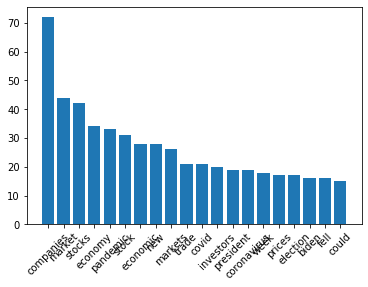

<Figure size 432x288 with 0 Axes>

In [173]:
import matplotlib.pyplot as plt

plt.bar(range(len(newdict)), list(newdict.values()), align='center')
plt.xticks(range(len(newdict)), list(newdict.keys()))
plt.xticks(rotation=45)
plt.show()
plt.savefig('commonwords2.png')

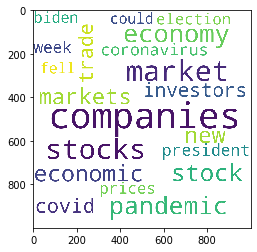

In [162]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(background_color="white",width=1000,height=1000, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(wordfreq)
plt.imshow(wc)
plt.savefig('wordcloud.png')

# Model Implementation

In [161]:
#from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, cross_val_score
#from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline

## Model Training

I based the code off of these sources:
* Naive Bayes: https://towardsdatascience.com/sentiment-analysis-introduction-to-naive-bayes-algorithm-96831d77ac91
* AdaBoost and SVC: https://www.datacamp.com/community/tutorials/adaboost-classifier-python 


We probably will need to run GridSearch to determine which parameters fit best for the model

In [ ]:
# USE THIS WHEN ITS ACTUALLY TIME TO TRAIN THE MODEL AND THEN TEST ON THE TWEETS

# split the Sentiment 140 training set with labeled sentiments into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(......, test_size = 0.2, random_state = 5) #change params to fit

In [ ]:
# implement kfold cross-validation
kf = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = None)

In [ ]:
# instantiate the Naive-Bayes Classifier
mnb = MultinomialNB()

# evaluate model
mnb_scores = cross_val_score(mnb, X, y, scoring = 'accuracy', cv = kf, n_jobs = -1)

print(f'Accuracy of the Naive-Bayes model:\t {%.3f (%.3f) % (mean(mnb_scores), std(mnb_scores))}')

In [ ]:
# instantiate the AdaBoost Decision Tree Classifier
dt = AdaBoostClassifier(n_estimators = 50, learning_rate = 1)

# evaluate model
dt_scores = cross_val_score(dt, X, y, scoring = 'accuracy', cv = kf, n_jobs = -1)

print(f'Accuracy of the Decision Tree model:\t {%.3f (%.3f) % (mean(dt_scores), std(dt_scores))}')

In [ ]:
# instantiate the AdaBoost Support Vector Classifier (SVC)
svc = SVC(probability = True, kernel = 'linear')

# create and fit the classifier
SVC = AdaBoostClassifier(base_estimator = svc, n_estimators = 50, learning_rate = 1)

# evaluate model
svc_scores = cross_val_score(svc, X, y, scoring = 'accuracy', cv = kf, n_jobs = -1)

print(f'Accuracy of the SVC model:\t {%.3f (%.3f) % (mean(svc_scores), std(svc_scores))}')

## Model Evaluation

To test different varieties, we could do:
* test different Naive Bayes algorithms (Gaussian and/or Bernoulli NB, along with Multinomial which we're currently using)
* test different AdaBoost algorithms (currently evaluating Decision Trees and Support Vector Classifier)

We could also consider using different BoW implementations to see if it changes our models' performance:
* use CountVectorizer() before any models are implemented, and we rely on the word counts of the features
* after implementing the models, we could then switch over to TD-IDF Vectorizer() and rely on the IDF scores

Metrics to Include for Presentation:
* F1 Score, Precision, Recall, Confusion Matrix?
* Which sentiment we classified most accurately
* after implementing the models, we could then switch over to TD-IDF Vectorizer() and rely on the IDF scores

In [ ]:
# evaluate Naive Bayes

# make predictions on the training set
MNB_predicted = MNB.predict(X_test)

# assess accuracy of the predictions
MNB_acc = accuracy_score(MNB_predicted, y_test)
print(f'Naive Bayes\'s accuracy on training dataset:\t {MNB_acc * 100}+%')

# print the confusion matrix
print(f'Naive Bayes confusion matrix:\n {confusion_matrix(MNB_predicted, y_test)}')

# print the classification report
print(classification_report(MNB_predicted, y_test))

In [ ]:
# evaluate AdaBoost

# make predictions on the training set
AB_predicted = AB.predict(X_test)

# assess accuracy of the predictions
AB_acc = accuracy_score(AB_predicted, y_test)
print(f'AdaBoost\'s accuracy on training dataset:\t {AB_acc * 100}+%')

# print the confusion matrix
print(f'AdaBoost confusion matrix:\n {confusion_matrix(AB_predicted, y_test)}')

# print the classification report
print(classification_report(AB_predicted, y_test))

In [ ]:
# evaluate SVC

# make predictions on the training set
SVC_predicted = SVC.predict(X_test)

# assess accuracy of the predictions
SVC_acc = accuracy_score(SVC_predicted, y_test)
print(f'SVC\'s accuracy on training dataset:\t {SVC_acc * 100}+%')

# print the confusion matrix
print(f'SVC confusion matrix:\n {confusion_matrix(SVC_predicted, y_test)}')

# print the classification report
print(classification_report(SVC_predicted, y_test))

In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

from keras.models import Model
from keras.layers import (
    Input, 
    Embedding, 
    Conv1D, 
    MaxPool1D, 
    Bidirectional, 
    CuDNNGRU, 
    CuDNNLSTM, 
    SpatialDropout1D, 
    Dropout, 
    Dense, 
    Concatenate, 
    Flatten
)


def cnn(init_layer, kernel_size, params):
    """
    Builds mutli-branch CNN
    """
    conv = Conv1D(filters=params["filters"], kernel_size=kernel_size, 
                  padding="valid", kernel_initializer=params["conv_init"])(init_layer)
    pooling = MaxPool1D(pool_size=params["pool_size"])(conv)
    x = eval(params["conv_activation"])(pooling)
    x = Dropout(params["dropout"])(x)
    
    for i in range(params["num_conv"] - 1):
        conv = Conv1D(filters=params["filters"], kernel_size=kernel_size, 
                      padding="valid", kernel_initializer=params["conv_init"])(x)
        pooling = MaxPool1D(pool_size=params["pool_size"])(conv)
        x = eval(params["conv_activation"])(pooling)
        x = Dropout(params["dropout"])(x)
        
    x = Flatten()(x)
        
    return x
    

def build_model(params: dict):
    inputs = Input(shape=(params["maxlen"],))
    
    embedding_weights = params["weights"]
    embeddings_layer = Embedding(input_dim=embedding_weights.shape[0], 
                          output_dim=embedding_weights.shape[1], 
                          weights=[embedding_weights], 
                          trainable=False)

    embeddings = embeddings_layer(inputs)

    # Add SpatialDropout1D
    x = SpatialDropout1D(params["spatial_dropout"])(embeddings)

    # Use single CuDNNLSTM layer
    lstm = CuDNNLSTM(params["lstm_state_size"], return_sequences=True)
    x = Bidirectional(lstm)(x)
    
    # CNN
    cnn_layers = []
    for i, ks in enumerate(params["cnn_kernel_sizes"]):
        conv = cnn(x, ks, params)
        cnn_layers.append(conv)
        
    x = Concatenate()(cnn_layers) if len(cnn_layers) > 1 else cnn_layers[0]
    
    # Build fully-connected classifier
    x = Dense(params["dense_1"], activation=params["dense_activation"])(x)
    
    x = Dropout(params["dropout"])(x)
    
    outputs = Dense(params["num_classes"], activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    lr = params["lr"]
    optimizer = params["optimizer"]
    opt = optimizer(lr=lr)
    
    loss = "binary_crossentropy"
    if params["num_classes"] > 2:
        loss = "categorical_crossentropy"
        
    model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
    return model


from keras import backend as K
from keras.optimizers import RMSprop
from keras.layers.advanced_activations import LeakyReLU

params = {
    "maxlen": maxlen,
    "weights": weights,
    "spatial_dropout": 0.2,
    "lstm_state_size": 100,
    "filters": 128,
    "cnn_kernel_sizes": [3, 5, 7],
    "conv_activation": "LeakyReLU(alpha=0.3)", 
    "conv_init": "he_normal",
    "pool_size": 4,
    "num_conv": 2,
    "dropout": 0.5,
    "dense_1": 128,
    "dense_activation": "relu",
    "num_classes": 2,
    "lr": 1e-3,
    "optimizer": RMSprop  # known good optimizer for RNNs
}

K.clear_session()

model = build_model(params)
model.summary()


from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor="val_acc",
                     min_delta=0.005,
                     patience=3,
                     factor=0.5),
    EarlyStopping(monitor="val_loss",
                 min_delta=0.005,
                 patience=3,
                 mode="auto",
                 restore_best_weights = True)
]

epochs = 10
batch_size = 256

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), callbacks=callbacks)

In [5]:


#hyperparams, can also alter activation function
max_features = 2000
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

NameError: name 'X' is not defined

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)